### Prepare space in /flash

In [1]:
import os, subprocess

In [2]:
cwd = os.path.basename(os.getcwd())
tmpdir = os.path.join("/flash/ReiterU/tmp/", cwd)
if not os.path.exists(tmpdir):
    os.makedirs(tmpdir)

### Load atlas image

In [3]:
from probemapper.io import load_nifti
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import h5py
from scipy import ndimage as ndi
from scipy.spatial.transform import Rotation as R

In [4]:
mpl.rcParams.update({
    'font.size': 14,
    'font.family': 'sans-serif',
    'font.sans-serif': "arial",
    'pdf.fonttype': 42,
    'ps.fonttype': 42})

In [5]:
atlas = load_nifti("/bucket/ReiterU/DBS/atlas/O_Laqueus_v0.2/nuclear_10um.nii")
mask = load_nifti("/bucket/ReiterU/DBS/atlas/O_Laqueus_v0.2/nuclear_10um_mask.nii.gz")
atlas[mask==0] = 0

In [6]:
# crop
atlas = atlas[70:, 30:440, 25:435]

# rotation
atlas = ndi.rotate(atlas, 225, axes=(0,1), reshape=False, order=3)
atlas = ndi.rotate(atlas, 5, axes=(0,2), reshape=False, order=3)

# flip
atlas = atlas[:, ::-1, :]
atlas = atlas.astype("float")

# gamma correction
atlas = np.power(atlas, 1/2.0)

In [7]:
atlas.shape

(410, 410, 410)

### Load LFP data

In [8]:
import pandas as pd
import numpy as np
import os, h5py
from probemapper.plot import merge_data_oct

In [9]:
lut = pd.read_csv("/bucket/ReiterU/DBS/atlas/O_Laqueus_v0.2/region_LUT.csv")
lut["region_name2"] = ["VL", "Others", "sFL", "iFL", "Buc", "Subfr", "aBL", "dBL", "Subv", "Prec"]
display(lut)

,ID,region_name,region_color,region_name2
0,1,Vertical Lobe,"128,174,128",VL
1,3,Others,"216,100,79",Others
2,4,Median superior frontal lobe + Lateral superio...,"216,100,79",sFL
3,5,Median inferior frontal lobe + Lateral inferio...,"255,147,114",iFL
4,6,Superior buccal lobe\n+ Posterior buccal lobe,"244,128,26",Buc
5,7,Subfrontal lobe,"251,202,0",Subfr
6,8,Anterior basal lobe,"89,114,255",aBL
7,9,Anterior dorsal basal lobe + Posterior dorsal ...,"82,145,163",dBL
8,11,Subvertical Lobe,"24,151,54",Subv
9,12,Precomissural,"255,170,255",Prec


In [10]:
data = [
    {
        "name": "L-J30",
        "channel_lut": "/bucket/ReiterU/DBS/data/20220526_P189_laqueus_DiI_L-J30/analysis/indexing/channel_LUT.csv",
        "offset": 0,
        "hdf5_column": 0,
    },
    {
        "name": "L-F11",
        "channel_lut": "/bucket/ReiterU/DBS/data/20220526_P190_laqueus_DiI_L-F11/analysis/indexing/channel_LUT.csv",
        "offset": 0,
        "hdf5_column": 1,
    },
    {
        "name": "L-M4",
        "channel_lut": "/bucket/ReiterU/DBS/data/20220321_P177_laqueus_DiI_3-8_CUBIC/analysis/indexing/channel_LUT.csv",
        "offset": 0,
        "hdf5_column": 2,
    },
    {
        "name": "L-M13",
        "channel_lut": "/bucket/ReiterU/DBS/data/20220529_P191_laqueus_DiI_LM13/analysis/indexing/channel_LUT.csv",
        "offset": 10,
        "hdf5_column": 3,
    },
    {
        "name": "L-M27",
        "channel_lut": "/bucket/ReiterU/DBS/data/20220517_P185_laqueus_DiI_L-M27/analysis/indexing/channel_LUT.csv",
        "offset": 0,
        "hdf5_column": 4,
    },
    {
        "name": "L-A1",
        "channel_lut": "/bucket/ReiterU/DBS/data/20220613_P200_laqueus_DiI_L-A1/analysis/indexing/channel_LUT.csv",
        "offset": 0,
        "hdf5_column": 5,
    },
    {
        "name": "L-A2",
        "channel_lut": "/bucket/ReiterU/DBS/data/20220518_P186_laqueus_DiI_L-A2/analysis/indexing/channel_LUT.csv",
        "offset": 10,
        "hdf5_column": 6,
    },
    {
        "name": "L-A11",
        "channel_lut": "/bucket/ReiterU/DBS/data/20220614_P201_laqueus_DiI_L-A11/analysis/indexing/channel_LUT.csv",
        "offset": 0,
        "hdf5_column": 7,
    },
    {
        "name": "L-A29",
        "channel_lut": "/bucket/ReiterU/DBS/data/20220615_P202_laqueus_DiI_L-A29/analysis/indexing/channel_LUT.csv",
        "offset": 0,
        "hdf5_column": 8,
    }
]

In [11]:
hdf_info = [
    {
        "path": "/bucket/ReiterU/octopus/electrophysiology/asBoutOverChans.h5",
        "key": "meanL",
        "name": "AS_low",
        "description": "Envelop intensity (a.u.) in 0.1-10 Hz band during AS"
    },
    {
        "path": "/bucket/ReiterU/octopus/electrophysiology/asBoutOverChans.h5",
        "key": "meanH",
        "name": "AS_high",
        "description": "Envelop intensity (a.u.) in 20-40 Hz band during AS"
    },
    {
        "path": "/bucket/ReiterU/octopus/electrophysiology/wakeBoutOverChans.h5",
        "key": "meanL",
        "name": "wake_low",
        "description": "Envelop intensity (a.u.) in 0.1-10 Hz band during wake"
    },
    {
        "path": "/bucket/ReiterU/octopus/electrophysiology/wakeBoutOverChans.h5",
        "key": "meanH",
        "name": "wake_high",
        "description": "Envelop intensity (a.u.) in 20-40 Hz band during wake"
    },
    {
        "path": "/bucket/ReiterU/octopus/electrophysiology/spindleRate.h5",
        "key": "smoothedRate",
        "name": "spindle_rate",
        "description": "Spindle rate (events per min) during QS"
    },
#     {
#         "path": "/bucket/ReiterU/octopus/electrophysiology/bceBoutOverChans.h5",
#         "key": "maxBCE",
#         "name": "BCE-LFP_xcr",
#         "description": "Correlation between BCE and LFP during QS"
#     },
    {
        "path": "/bucket/ReiterU/octopus/electrophysiology/vleRate.h5",
        "key": "smoothedRate",
        "name": "VLE_rate",
        "description": "VLE rate"
    },
]

In [12]:
probes = merge_data_oct(data, hdf_info, lut)
display(probes)

,channel,X,Y,Z,X_org,Y_org,Z_org,Region,Region_name,Region_color,AS_low,AS_high,wake_low,wake_high,spindle_rate,VLE_rate,probe
0,0,188.530,182.238,151.016,1787.73,2235.010,1369.73,7,Subfr,"[251, 202, 0]",8.518759,2.334061,10.401586,2.110385,0.002035,0.009922,L-J30
1,1,189.106,182.020,151.850,1790.54,2227.030,1374.33,6,Buc,"[244, 128, 26]",8.835407,2.361447,13.591631,2.166310,0.002358,0.009922,L-J30
2,2,189.691,181.804,152.705,1793.35,2219.050,1378.92,6,Buc,"[244, 128, 26]",8.909921,2.373251,14.850384,2.196717,0.002367,0.011709,L-J30
3,3,190.277,181.584,153.564,1796.16,2211.070,1383.52,6,Buc,"[244, 128, 26]",9.576357,2.376796,15.877340,2.217343,0.002367,0.011709,L-J30
4,4,190.866,181.371,154.449,1798.97,2203.080,1388.11,6,Buc,"[244, 128, 26]",8.983270,2.380791,21.294446,2.236543,0.002619,0.014387,L-J30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1963,182,242.226,151.987,424.261,1992.10,478.734,2870.82,1,VL,"[128, 174, 128]",10.558875,2.189759,12.305204,2.172192,0.001230,0.006667,L-A29
1964,183,242.312,151.292,425.283,1991.75,469.050,2873.30,1,VL,"[128, 174, 128]",9.980774,2.102473,12.726490,2.110333,0.001230,0.005833,L-A29
1965,184,242.384,150.592,426.303,1991.21,459.367,2875.72,1,VL,"[128, 174, 128]",9.275137,2.259629,13.811373,2.297971,0.001230,0.005833,L-A29
1966,185,242.443,149.871,427.341,1990.49,449.684,2878.09,1,VL,"[128, 174, 128]",8.680659,2.062042,12.443102,2.090892,0.001230,0.003333,L-A29


In [13]:
# Transform coordinates
xyz = probes[["X", "Y", "Z"]].to_numpy()
xyz[:, 0] -= 25
xyz[:, 1] -= 30
xyz[:, 2] -= 70
# rotation along x axis
r1 = R.from_euler('x', -225, degrees=True)
xyz -= np.array([0, atlas.shape[1]/2, atlas.shape[0]/2])
xyz = r1.apply(xyz)
xyz += np.array([0, atlas.shape[1]/2, atlas.shape[0]/2])
# rotation along yaxis
r2 = R.from_euler('y', 5, degrees=True)
xyz -= np.array([atlas.shape[2]/2, 0, atlas.shape[0]/2])
xyz = r2.apply(xyz)
xyz += np.array([atlas.shape[2]/2, 0, atlas.shape[0]/2])
# flip Y
xyz[:,1] = atlas.shape[1] - xyz[:,1]

probes["X_trnsf"] = xyz[:, 0]
probes["Y_trnsf"] = xyz[:, 1]
probes["Z_trnsf"] = xyz[:, 2]

In [14]:
# def overlay2(atlas, probes, column, ori, start, end, step, thickness, vmin, vmax, projection="maximum", savename=None):
    
#     fig = plt.figure(figsize=(360/25.4, 200/25.4))
    
#     for (j, s) in enumerate(range(start, end, step)):
#         ax = fig.add_subplot(1,8,j+1)
    
#         for p in probes:
            
#             xyz = p["xyz"]
#             val = p[column]
#             if ori == "sagittal":
#                 idx = np.where(np.logical_and(xyz[:, 0] > s, xyz[:, 0] < s+thickness))
#             elif ori == "coronal":
#                 idx = np.where(np.logical_and(xyz[:, 1] > s, xyz[:, 1] < s+thickness))
#             xyz = xyz[idx]
#             power = val[idx]
#             if ori == "sagittal":
#                 x = xyz[:, 1]
#                 y = xyz[:, 2]
#             elif ori == "coronal":
#                 x = xyz[:, 0]
#                 y = xyz[:, 2]
#             #ax.scatter(x, y, c=power, cmap="jet", vmin=vmin, vmax=vmax, marker="o", s=5, edgecolors=None, alpha=0.4)
#             ax.scatter(x[::2], y[::2], c=power[::2], cmap="jet", vmin=vmin, vmax=vmax, marker="o", s=5, edgecolors=None, alpha=0.5)

#         if ori == "sagittal":
#             plane = atlas[:, :, s:s+thickness]
#             if projection == "maximum":
#                 plane = plane.max(axis=2)
#             else:
#                 plane = plane[:, :, int(plane.shape[2]/2)]
#         elif ori == "coronal":
#             plane = atlas[:, s:s+thickness, :]
#             if projection == "maximum":
#                 plane = plane.max(axis=1)
#             else:
#                 plane = plane[:, int(plane.shape[1]/2), :]
        
#         #ax.set_title(f"{s*10} $\mu$m")
#         ax.imshow(plane, cmap="gray_r", vmin=0, vmax=100)
#         ax.axis("off")
#     plt.tight_layout()
#     if savename is not None:
#         plt.savefig(savename, dpi=300, bbox_inches="tight")
#     plt.show()


In [15]:
def overlay3(atlas, df, column, ori, start, end, thickness, vmin, vmax, projection="maximum", savename=None):
    
    fig = plt.figure(figsize=(360/25.4, 180/25.4))
    samples = list(df["probe"].unique())
    
    th = (end-start)/8
    print(th)
    
    for (j, s) in enumerate(np.linspace(start, end, 8, dtype=int)):
        ax = fig.add_subplot(1,8,j+1)
        for sample in samples:
            data = df[df["probe"]==sample]
            xyz = data[["X_trnsf", "Y_trnsf", "Z_trnsf"]].to_numpy()
            val = data[column].to_numpy()
            if ori == "sagittal":
                idx = np.where(np.logical_and(xyz[:, 0] >= s - thickness/2, xyz[:, 0] <= s + thickness/2))
            elif ori == "coronal":
                idx = np.where(np.logical_and(xyz[:, 1] >= s - thickness/2, xyz[:, 1] <= s + thickness/2))
            xyz = xyz[idx]
            val = val[idx]
            if ori == "sagittal":
                x = xyz[:, 1]
                y = xyz[:, 2]
            elif ori == "coronal":
                x = xyz[:, 0]
                y = xyz[:, 2]
            ax.scatter(x[::2], y[::2], c=val[::2], cmap="jet", vmin=vmin, vmax=vmax, marker="o", s=0.75, edgecolors=None, alpha=1.0)

        if ori == "sagittal":
            plane = atlas[:, :, s-int(thickness/2):s+int(thickness/2)]
            if projection == "maximum":
                plane = plane.max(axis=2)
            else:
                plane = plane[:, :, int(plane.shape[2]/2)]
        elif ori == "coronal":
            plane = atlas[:, s-int(thickness/2):s+int(thickness/2), :]
            if projection == "maximum":
                plane = plane.max(axis=1)
            else:
                plane = plane[:, int(plane.shape[1]/2), :]
        ax.imshow(plane, cmap="gray_r", vmin=0, vmax=125)
        ax.axis("off")
    plt.tight_layout()
    if savename is not None:
        plt.savefig(savename, dpi=300, bbox_inches="tight", transparent=True)
    plt.show()

8.75


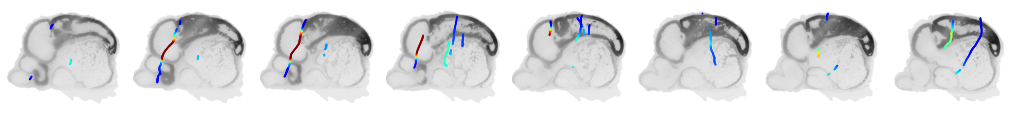

In [16]:
overlay3(atlas, probes, column="AS_high", ori="sagittal", start=170, end=240, thickness=10,
         vmin=1, vmax=12, projection="center", savename=os.path.join(tmpdir, "AS_highfreq_sagittal.pdf"))

30.0


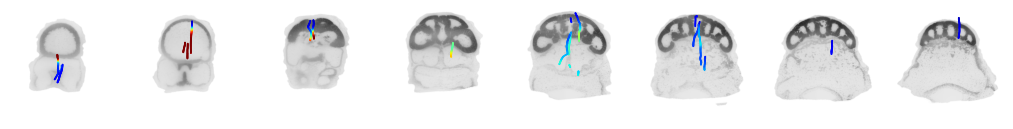

In [17]:
overlay3(atlas, probes, column="AS_high", ori="coronal", start=90, end=330, thickness=30,
         vmin=1, vmax=12, projection="center", savename=os.path.join(tmpdir, "AS_highfreq_coronal.pdf"))

8.75


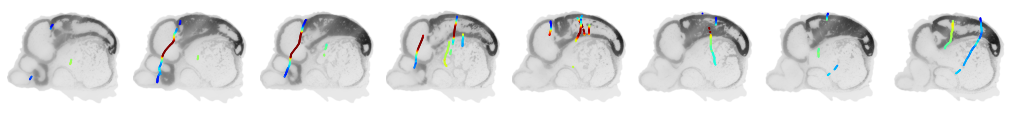

In [18]:
overlay3(atlas, probes, column="AS_low", ori="sagittal", start=170, end=240, thickness=10,
         vmin=1, vmax=45, projection="center", savename=os.path.join(tmpdir, "AS_lowfreq_sagittal.pdf"))

30.0


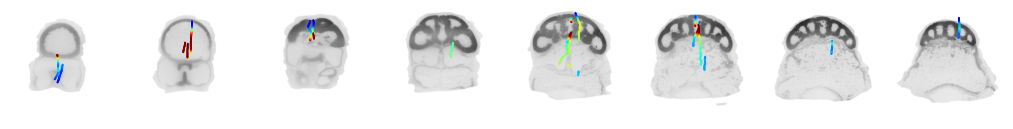

In [19]:
overlay3(atlas, probes, column="AS_low", ori="coronal", start=90, end=330, thickness=30,
         vmin=1, vmax=45, projection="center", savename=os.path.join(tmpdir, "AS_lowfreq_coronal.pdf"))

8.75


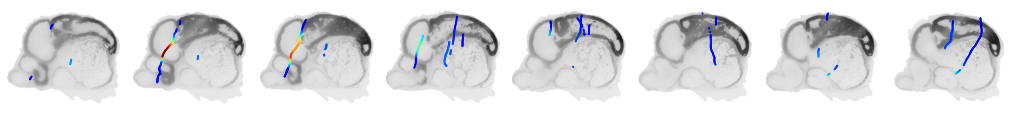

In [20]:
overlay3(atlas, probes, column="wake_high", ori="sagittal", start=170, end=240, thickness=10,
         vmin=1, vmax=12, projection="center", savename=os.path.join(tmpdir, "wake_highfreq_sagittal.pdf"))

30.0


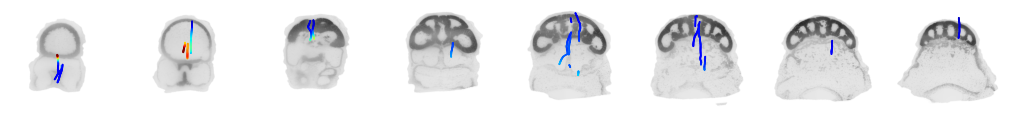

In [21]:
overlay3(atlas, probes, column="wake_high", ori="coronal", start=90, end=330, thickness=30,
         vmin=1, vmax=12, projection="center", savename=os.path.join(tmpdir, "wake_highfreq_coronal.pdf"))

8.75


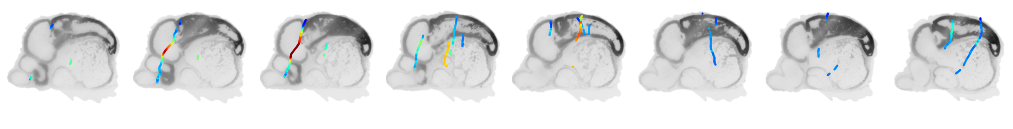

In [22]:
overlay3(atlas, probes, column="wake_low", ori="sagittal", start=170, end=240, thickness=10,
         vmin=1, vmax=45, projection="center", savename=os.path.join(tmpdir, "wake_lowfreq_sagittal.pdf"))

30.0


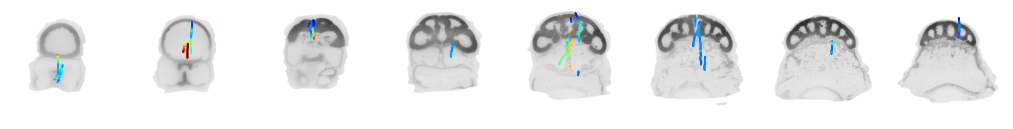

In [23]:
overlay3(atlas, probes, column="wake_low", ori="coronal", start=90, end=330, thickness=30,
         vmin=1, vmax=45, projection="center", savename=os.path.join(tmpdir, "wake_lowfreq_coronal.pdf"))

8.75


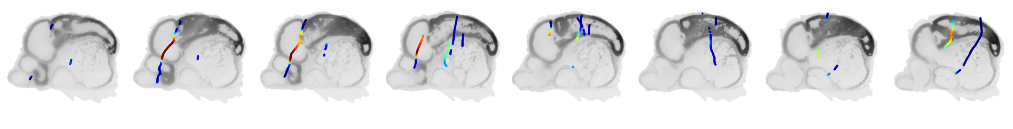

In [24]:
overlay3(atlas, probes, column="spindle_rate", ori="sagittal", start=170, end=240, thickness=10,
         vmin=0, vmax=0.075, projection="center", savename=os.path.join(tmpdir, "spindle_rate_sagittal.pdf"))

30.0


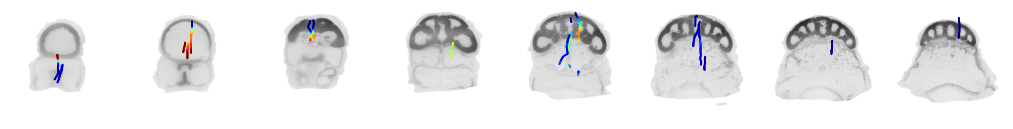

In [25]:
overlay3(atlas, probes, column="spindle_rate", ori="coronal", start=90, end=330, thickness=30,
         vmin=0, vmax=0.075, projection="center", savename=os.path.join(tmpdir, "spindle_rate_coronal.pdf"))

### Copy data to bucket

In [26]:
resultdir = "/bucket/ReiterU/DBS/analysis/221026_probe_image_overlay"
if not os.path.exists(resultdir):
    subprocess.run(["ssh", "deigo", "mkdir", resultdir])

In [27]:
subprocess.run(["scp", "-r", tmpdir, f"deigo:{resultdir}"])

CompletedProcess(args=['scp', '-r', '/flash/ReiterU/tmp/221026_probe_image_overlay', 'deigo:/bucket/ReiterU/DBS/analysis/221026_probe_image_overlay'], returncode=0)